# Práctica Espectropolarimetría en Astrofísica

### “ZEEMAN DOPPLER IMAGING” DE UNA SUPERFICIE ESTELAR

David Mirabal Betancort

In [2]:
import struct 

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.style.use('figure_style.mplstyle')

#### Carga de la simulación:

In [3]:
with open('data', 'rb') as f:
    nt = struct.unpack('i', f.read(4))[0] # número de tiempos
    nl = struct.unpack('i', f.read(4))[0] # número de longitudes de onda
    wave = np.array(struct.unpack('d'*nl, f.read(8*nl))) # longitudes de onda
    stokes_0 = np.array(struct.unpack('d'*nl*4, f.read(8*4*nl))).reshape((4, nl)) # parámetros de Stokes (estrella en calma)
    stokes = np.array(struct.unpack('d'*nl*4*nt, f.read(8*nl*4*nt))).reshape((nt, 4, nl)) # parámetros de Stokes (estrella con actividad)

#### 1- Identificando la actividad magnética tipo solar en otras superficies estelares.

In [4]:
residuo = stokes - stokes_0 # residuo

Perfil en intensidad de la estrella en calma y de la estrella con actividad cuando la mancha pasa por el meridiano central. Se añade el residuo:

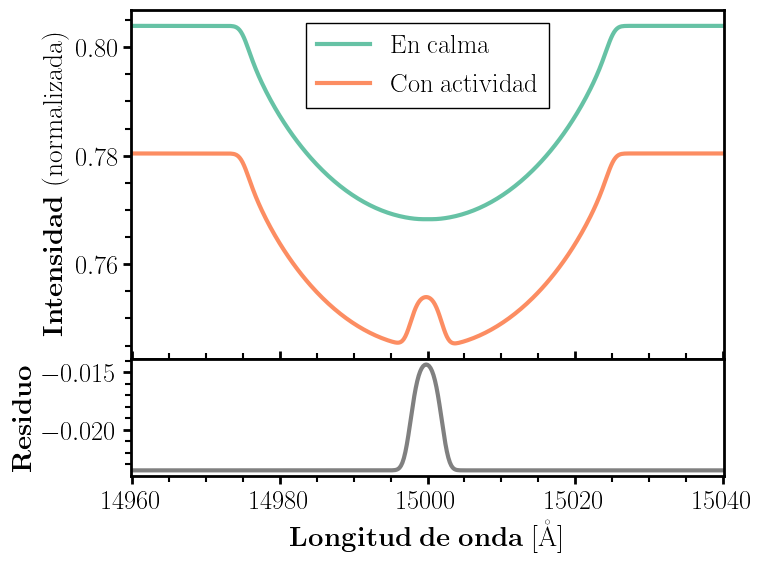

In [5]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1])
color1 = "#66c2a5" 
color2 = "#fc8d62"  

ax[0].plot(wave, stokes_0[0], c=color1, lw=3, label=r'$\rm{En\; calma}$')
ax[0].plot(wave, stokes[21, 0, :], c=color2, lw=3, label=r'$\rm{Con\; actividad}$')
ax[1].plot(wave, residuo[21, 0], c='grey', lw=3)

ax[0].tick_params(axis='x', which='both', direction='in', labelbottom=False)
ax[0].set_xlim(wave.min(), wave.max())
ax[1].set_xlim(wave.min(), wave.max())
ax[0].legend()

ax[1].set_xlabel(r'$\mathbf{Longitud\; de\; onda}\; \rm{[\mathring{A}]}$')
ax[0].set_ylabel(r'$\mathbf{Intensidad}\; \rm{(normalizada)}$')
ax[1].set_ylabel(r'$\mathbf{Residuo}$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig('figures/perfil_intensidad_residuo.pdf')

#### 2- Mapeado de la actividad estelar

2.1 Cálculo de la latitud de la región activa

Parámetros de Stokes de la estrella con actividad para 3 momentos distintos:

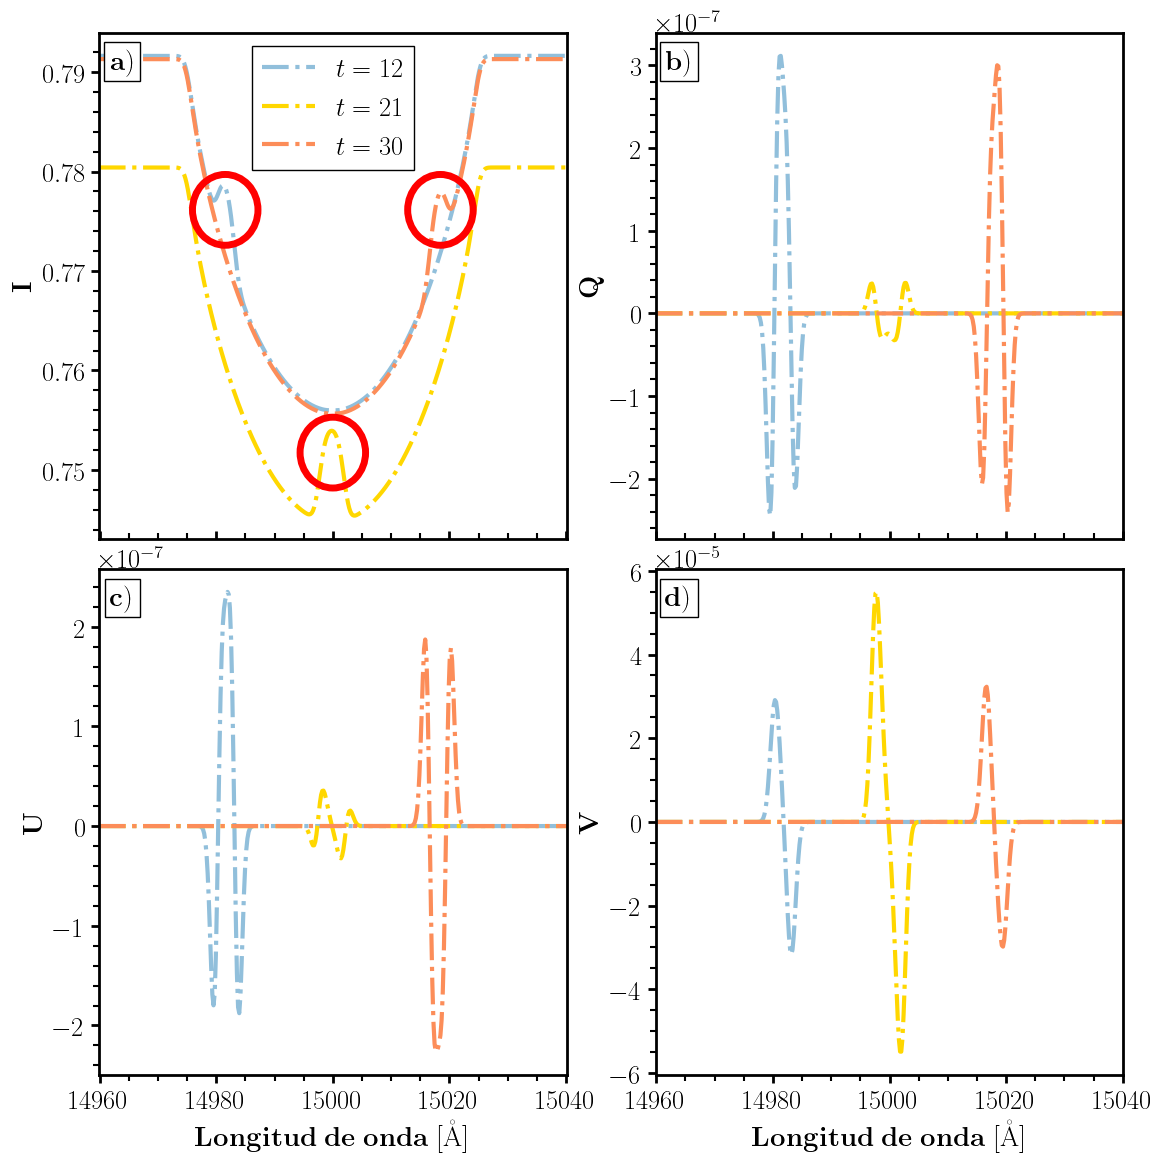

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
idx = [12, 21, 30]
colors = ['#91bfdb', 'gold', '#fc8d59']
idx_wave = [106, 200, 293]
labels = ['$\mathbf{a)}$', '$\mathbf{b)}$', '$\mathbf{c)}$', '$\mathbf{d)}$']

k=0
for ax in axs.flatten():
    j=0
    ax.text(0.05, 0.97, labels[k], transform=ax.transAxes, fontsize=20,
               verticalalignment='top', horizontalalignment='center',
               bbox=dict(facecolor='white', edgecolor='black'))
    
    for i in idx:
        ax.plot(wave, stokes[i, k, :], c=colors[j], lw=3, ls='-.',label=r'$t = {:d}$'.format(i))
    
        j+=1
    k += 1

    ax.set_xlim(wave.min(), wave.max())

xy_fig = [(0.27, 0.65), (0.50, 0.17), (0.73, 0.65)]
for i in range(3):
    circle = plt.Circle(xy_fig[i], 0.07, color='red', fill=False, transform=axs.flatten()[0].transAxes, lw=5, zorder=10)
    axs.flatten()[0].add_patch(circle)
    
for ax in axs.flatten()[:2]:
    ax.set_xticklabels([])
    ax.tick_params(axis='x', direction='in', which='both')
for ax in axs.flatten()[2:4]:
    ax.set_xlabel(r'$\mathbf{Longitud\; de\; onda}\; \rm{[\mathring{A}]}$')

axs[0,0].set_ylabel(r'$\mathbf{I}$')
axs[0,1].set_ylabel(r'$\mathbf{Q}$')
axs[1,0].set_ylabel(r'$\mathbf{U}$')
axs[1,1].set_ylabel(r'$\mathbf{V}$')
axs[0, 0].legend()

fig.tight_layout()
fig.subplots_adjust(hspace=0.06, wspace=0.19)
fig.savefig('figures/stokes_mancha_3tiempos.pdf')

Velocidad del rasgo en función de la fase

In [25]:
# Expresión analítica de la velocidad de la mancha en la línea de visión
def vlos(fase, lat, v=500, i=np.pi/2):
    fase = fase*np.pi/180
    return v*np.sin(fase)*np.sin(i)*np.cos(lat)

# Modelo de la V_los centrando la fase
def vlos_model(fase, lat):
    return vlos(fase - fase[17], lat, 500, np.pi/2)


delta_lambda = 20
vlos_obs = np.linspace(-40*delta_lambda, 40*delta_lambda, nl) # [km/s]	
idx_wv_pico = np.argmax(stokes[:, 0, :]-stokes_0[0], axis=1)  # índice de la longitud de onda del pico del residuo
mask = np.max(stokes[:, 0, :]-stokes_0[0], axis=1) != 0.0     # máscara para eliminar los tiempos donde no se ve la mancha (residuo=0)

fase = np.linspace(0, 360, nt)   # fase en grados


fit, pcov = curve_fit(vlos_model, fase[mask], vlos_obs[idx_wv_pico][mask], p0=[18*np.pi/180])

print(f"Latitud ajustada: {fit[0]*180/np.pi:.2f} grados")

fit_rect = np.polyfit(fase[mask][np.sum(mask)//2 - 8:np.sum(mask)//2 + 8]*np.pi/180, vlos_obs[idx_wv_pico][mask][np.sum(mask)//2 - 8:np.sum(mask)//2 + 8], 1)
print(f"Recta: v_los = {fit_rect[0]:.2f} [km/s / rad] * fase [rad] + {fit_rect[1]:.2f} [rad]")


Latitud ajustada: 18.98 grados
Recta: v_los = 437.40 [km/s / rad] * fase [rad] + -904.29 [rad]


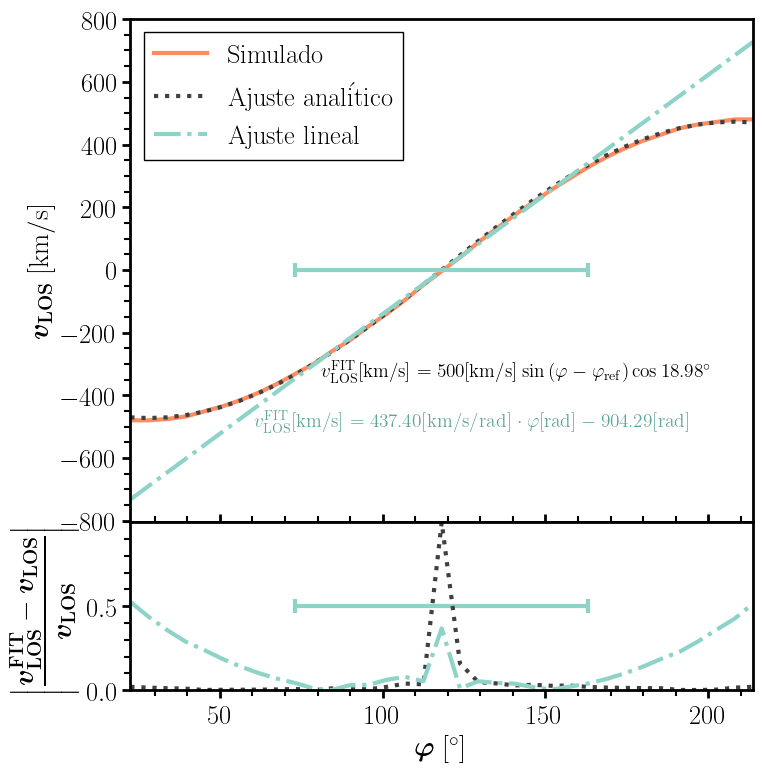

In [30]:
fig, ax = plt.subplots(2,1, figsize=(8, 8), height_ratios=[3, 1])
ax[0].plot(fase[mask], vlos_obs[idx_wv_pico][mask], c="#fc8d62", lw=3, label=r'$\rm{Simulado}$')
ax[0].plot(fase[mask], vlos_model(fase[mask], fit[0]), c="#404040", lw=3, ls=':', label=r"$\mathrm{Ajuste\;anal\acute{i}tico}$")
ax[0].plot(fase[mask], np.polyval(fit_rect,fase[mask]*np.pi/180), c="#8dd3c7", lw=3, ls='-.', label = (r'$\mathrm{Ajuste\;lineal}$'))

ax[0].text(0.62, 0.30, r'$v_\mathrm{LOS}^\mathrm{FIT} \mathrm{[km/s]} = 500\mathrm{[km/s]}\sin{(\varphi - \varphi_\mathrm{ref})}\cos{18.98^\circ}$', transform=ax[0].transAxes, fontsize=14,
           verticalalignment='center', horizontalalignment='center')
ax[0].text(0.55, 0.20, r'$v_\mathrm{LOS}^\mathrm{FIT} \mathrm{[km/s]} = ' + f'{fit_rect[0]:.2f}' + r'\rm{[km/s/rad]}\cdot \varphi\rm{[rad]}' + f' {fit_rect[1]:.2f} [rad]$', transform=ax[0].transAxes, fontsize=14,
           verticalalignment='center', horizontalalignment='center', c="#5ea59b")

error_analitico_abs = vlos(fase[mask]- fase[mask][17], fit[0]) - vlos_obs[idx_wv_pico][mask]
error_lineal_abs = np.polyval(fit_rect,fase[mask]*np.pi/180) - vlos_obs[idx_wv_pico][mask]

error_analitico = error_analitico_abs/vlos_obs[idx_wv_pico][mask]
error_lineal = error_lineal_abs/vlos_obs[idx_wv_pico][mask]

ax[0].errorbar(fase[mask][np.sum(mask)//2], 0, xerr=(fase[mask][np.sum(mask)//2 + 8] - fase[mask][np.sum(mask)//2 - 8])/2,  c='#8dd3c7', marker='', lw=3,capsize=5, capthick=3)
ax[1].errorbar(fase[mask][np.sum(mask)//2], 0.5, xerr=(fase[mask][np.sum(mask)//2 + 8] - fase[mask][np.sum(mask)//2 - 8])/2,  c='#8dd3c7', marker='', lw=3,capsize=5, capthick=3)

ax[1].plot(fase[mask], np.abs(error_analitico), 
           c="#404040", lw=3, ls=':')
ax[1].plot(fase[mask], np.abs(error_lineal), 
           c="#8dd3c7", lw=3, ls='-.')


ax[1].set_xlabel(r'$\boldsymbol{\varphi} \; \mathrm{[^\circ]}$')
ax[0].set_ylabel(r'$\boldsymbol{v_\mathrm{LOS}} \; \mathrm{[km/s]}$')
ax[1].set_ylabel(r'$\left|\dfrac{\boldsymbol{v_\mathrm{LOS}^\mathrm{FIT}} - \boldsymbol{v_\mathrm{LOS}}}{\boldsymbol{v_\mathrm{LOS}}}\right|$')

ax[0].tick_params(axis='x', which='both', direction='in', labelbottom=False)
ax[0].set_xlim(fase[mask].min(), fase[mask].max())
ax[1].set_xlim(fase[mask].min(), fase[mask].max())
ax[1].set_ylim(0, 1)
ax[1].set_yticks([0, 0.5])
ax[0].legend()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig('figures/vlos_fase.pdf')

In [9]:
print(f'Error medio del ajuste analítico: {np.mean(np.abs(error_analitico_abs)):.2f} km/s')
print(f'Error medio del ajuste lineal: {np.mean(np.abs(error_lineal_abs)):.1f} km/s')

Error medio del ajuste analítico: 3.96 km/s
Error medio del ajuste lineal: 55.6 km/s


In [10]:
print(f'Error máximo del ajuste analítico: {np.max(np.abs(error_analitico_abs)):.2f} km/s')
print(f'Error máximo del ajuste lineal:  {np.max(np.abs(error_lineal_abs)):.0f} km/s')

Error máximo del ajuste analítico: 9.46 km/s
Error máximo del ajuste lineal:  228 km/s


2.3- Cálculo del campo magnético de la región activa 

In [11]:
# Función para calcular el campo magnético
def inversion(I_obs, Q_obs, U_obs, V_obs):
    C = 4.67e-13 # A^-1 G^-1 
    g_eff = 1
    lambda_0 = 15e3 # A

    A = -C**2 / 4 * g_eff**2 * lambda_0**4
    D = -C * g_eff * lambda_0**2
    
    dI = np.gradient(I_obs, wave, axis=1)  # Derivada de la intensidad
    d2_I = np.gradient(dI, wave, axis=1)   # Segunda derivada de la intensidad
    
    phi = 0.5 * np.arctan2(np.nansum(U_obs*d2_I, axis=1),np.nansum(Q_obs*d2_I, axis=1))
    phi = phi[:, np.newaxis]
    
    B_per = np.sqrt(-np.nansum((Q_obs*np.cos(2*phi) + U_obs*np.sin(2*phi))*d2_I, axis=1)/(A * np.nansum(d2_I**2, axis=1)))
    B_par = np.nansum(V_obs * dI, axis=1) / (D * np.nansum(dI**2, axis=1))
    
    theta = np.arctan2(B_per,B_par)
    B = np.sqrt(B_per**2 + B_par**2)
    
    return B, B_per, B_par, theta, phi
    

In [12]:
# Sin normalización
I_obs = -residuo[:, 0]/4
Q_obs = stokes[:, 1, :]
U_obs = stokes[:, 2, :]
V_obs = stokes[:, 3, :]

B, B_per, B_par, theta, phi = inversion(I_obs, Q_obs, U_obs, V_obs)

# Seeing estable (normalización al continuo de uno de los instantes temporales)
I_obs = (-(stokes[:, 0, :] - stokes_0[0])/4) / stokes[0, 0, 0]
Q_obs = stokes[:, 1, :] / stokes[0, 0, 0]
U_obs = stokes[:, 2, :] / stokes[0, 0, 0]
V_obs = stokes[:, 3, :] / stokes[0, 0, 0]

B_scte, B_per_scte, B_par_scte, theta_scte, phi_scte = inversion(I_obs, Q_obs, U_obs, V_obs)

# Seeing variable (normalización al continuo de cada uno de los instantes temporales)
I_obs = (-(stokes[:, 0, :] - stokes_0[0])/4) / stokes[:, 0, 0][:, np.newaxis]
Q_obs = stokes[:, 1, :] / stokes[:, 0, 0][:, np.newaxis]
U_obs = stokes[:, 2, :] / stokes[:, 0, 0][:, np.newaxis]
V_obs = stokes[:, 3, :] / stokes[:, 0, 0][:, np.newaxis]

B_svar, B_per_svar, B_par_svar, theta_svar, phi_svar = inversion(I_obs, Q_obs, U_obs, V_obs)

C:\Users\mirab\AppData\Local\Temp\ipykernel_29252\2060956400.py:16: RuntimeWarning: invalid value encountered in divide
  B_per = np.sqrt(-np.nansum((Q_obs*np.cos(2*phi) + U_obs*np.sin(2*phi))*d2_I, axis=1)/(A * np.nansum(d2_I**2, axis=1)))
C:\Users\mirab\AppData\Local\Temp\ipykernel_29252\2060956400.py:17: RuntimeWarning: invalid value encountered in divide
  B_par = np.nansum(V_obs * dI, axis=1) / (D * np.nansum(dI**2, axis=1))


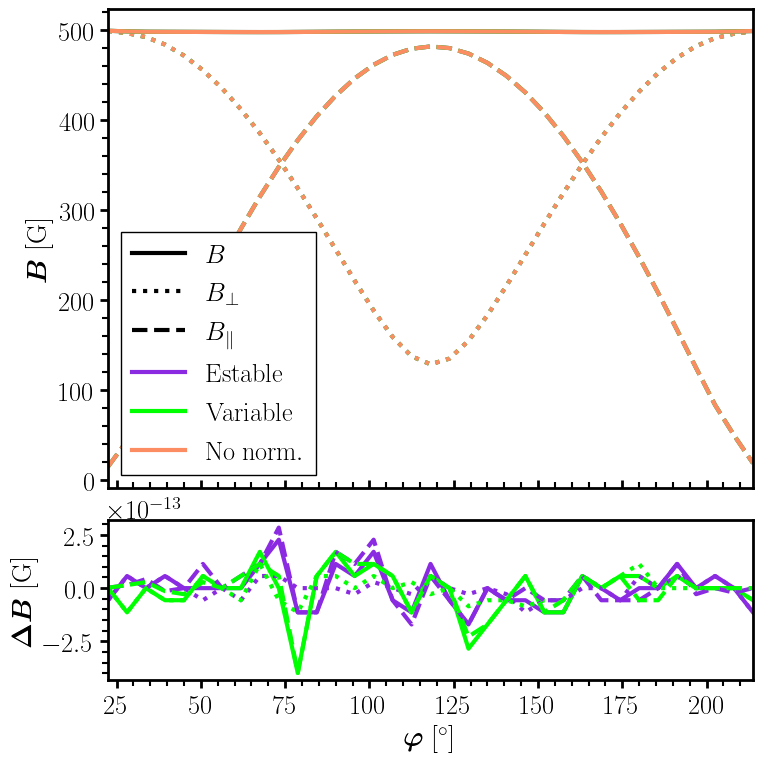

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), height_ratios=[3, 1])

ax = axs[0]

ax.plot(fase[mask]+10e10, B[mask], lw=3, c="#fc8d62", label=r'$B$')
ax.plot(fase[mask], B_per_scte[mask], lw=3, c="blueviolet", ls=':', label=r'$B_{\perp}$')
ax.plot(fase[mask], B_per_svar[mask], lw=3, c="lime", ls=':')
ax.plot(fase[mask], B_per[mask], lw=3, c="#fc8d62", ls=':')

ax.plot(fase[mask], B_par_scte[mask], lw=3, c="blueviolet", ls='--', label=r'$B_{\parallel}$')
ax.plot(fase[mask], B_par_svar[mask], lw=3, c="lime", ls='--')
ax.plot(fase[mask], B_par[mask], lw=3, c="#fc8d62", ls='--')

ax.plot(fase[mask], B_scte[mask], lw=3, c="blueviolet", label=r'$\mathrm{Estable}$')
ax.plot(fase[mask], B_svar[mask], lw=3, c="lime", label=r'$\mathrm{Variable}$')
ax.plot(fase[mask], B[mask], lw=3, c="#fc8d62", label=r'$\mathrm{No\;norm.}$')



ax.set_xlim(fase[mask].min(), fase[mask].max())
ax.tick_params(axis='x', which='both', direction='in', labelbottom=False)
ax.set_ylabel(r'$\boldsymbol{B} \; \mathrm{[G]}$')
legend = ax.legend()

for line in legend.get_lines()[:3]:
    line.set_color("black")
    
ax = axs[1]
ax.plot(fase[mask], B[mask] - B_scte[mask], lw=3, c="blueviolet")
ax.plot(fase[mask], B[mask] - B_svar[mask], lw=3, c="lime")

ax.plot(fase[mask], B_per[mask] - B_per_scte[mask], lw=3, c="blueviolet", ls=':')
ax.plot(fase[mask], B_per[mask]- B_per_svar[mask], lw=3, c="lime", ls=':')

ax.plot(fase[mask],  B_par[mask]- B_par_scte[mask], lw=3, c="blueviolet", ls='--')
ax.plot(fase[mask],  B_par[mask]- B_par_svar[mask], lw=3, c="lime", ls='--')

ax.set_xlim(fase[mask].min(), fase[mask].max())
ax.set_xlabel(r'$\boldsymbol{\varphi} \; \mathrm{[^\circ]}$')
ax.set_ylabel(r'$\boldsymbol{\Delta B} \; \mathrm{[G]}$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.savefig('figures/campo_magnetico.pdf')
